# Emotion Classification in texts using LSTM and Word2Vec


In [47]:
#Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [48]:
# Installing the Keras Dependency
!sudo pip install np_utils

In [49]:
# Import Data
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

In [50]:
#Defining vector space dimension and fixed input size

# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [51]:
data_train = pd.read_csv('/content/drive/MyDrive/Capstone/data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('/content/drive/MyDrive/Capstone/data/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [52]:
print(data.Emotion.value_counts())
data.head(6)

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


In [53]:
#To input the data to our NN Model we'll need some preprocessing:

#Tokenize our texts and count unique tokens
#Padding: each input (sentence or text) has to be of the same lenght
#Labels have to be converted to integeres and categorized

def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [54]:
#using the NLTK Downloader to obtain the resource
import nltk
nltk.download('punkt')

texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
print(texts_train[92])

a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .


In [56]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12088


In [57]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10259,   173,    13]], dtype=int32)

In [58]:
#Categorizing the labels

encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [59]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [60]:
#Importing the pretrained words

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [61]:
#We can download and import any pre-trained word embeddings.
#We will use 300 dimentional w2v pre-trained on wikipedia articles.
#Free Resource : https://fasttext.cc/docs/en/english-vectors.html

import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [62]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12089, 300)

In [63]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 646


## 3. Create LSTM Pipeline

In [64]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

### Model Pipeline


In [65]:
# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [66]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3626700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 3,958,225
Trainable params: 331,525
Non-trainable params: 3,626,700
_________________________________________________________________


## 3. Train the Model

In [67]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/15
62/62 [==============================] - 513s 8s/step - loss: 1.4930 - accuracy: 0.3425 - val_loss: 1.2685 - val_accuracy: 0.4786
Epoch 2/15
62/62 [==============================] - 536s 9s/step - loss: 1.1788 - accuracy: 0.5299 - val_loss: 0.9988 - val_accuracy: 0.6207
Epoch 3/15
62/62 [==============================] - 510s 8s/step - loss: 0.8980 - accuracy: 0.6714 - val_loss: 0.8482 - val_accuracy: 0.6970
Epoch 4/15
62/62 [==============================] - 519s 8s/step - loss: 0.8055 - accuracy: 0.7091 - val_loss: 0.8056 - val_accuracy: 0.7073
Epoch 5/15
62/62 [==============================] - 514s 8s/step - loss: 0.7328 - accuracy: 0.7427 - val_loss: 0.7992 - val_accuracy: 0.7050
Epoch 6/15
62/62 [==============================] - 513s 8s/step - loss: 0.7289 - accuracy: 0.7424 - val_loss: 0.7706 - val_accuracy: 0.7177
Epoch 7/15
62/62 [==============================] - 508s 8s/step - loss: 0.6831 - accuracy: 0.7535 - val_loss: 0.7555 - val_accuracy: 0.7215
Epoch 8/15
62

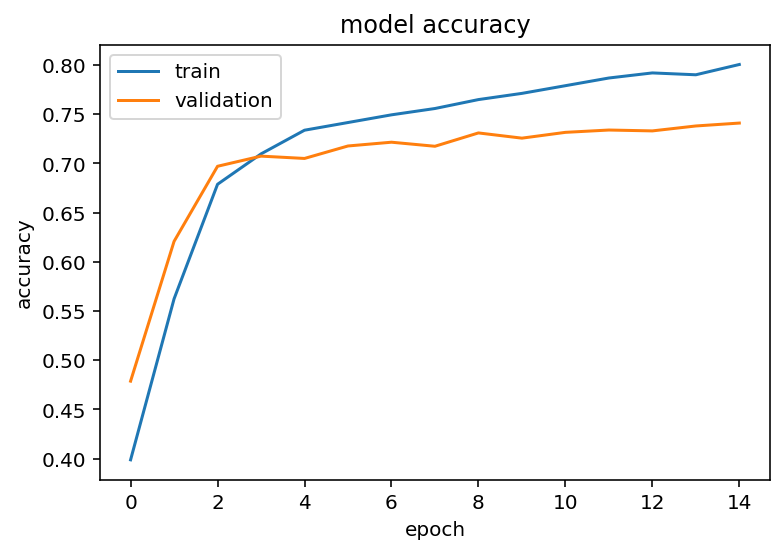

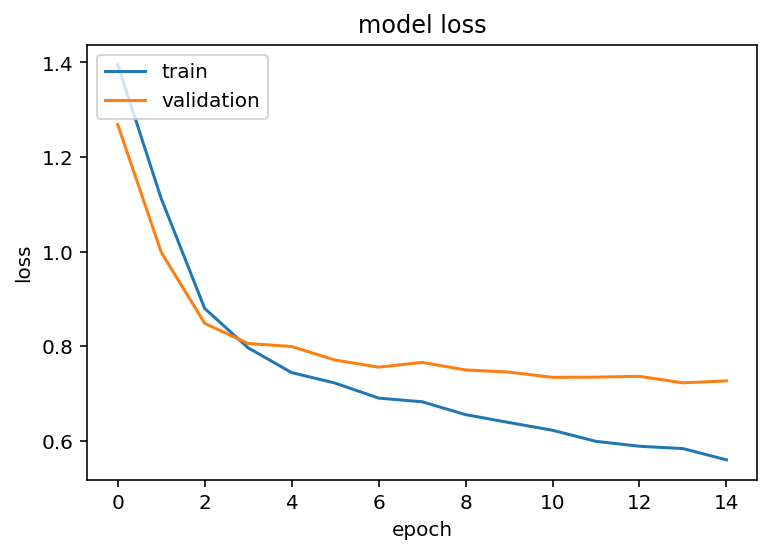

In [68]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. Evaluation

In [81]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [82]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 74.09%

F1 Score: 74.09


# Done
Save the model for later use  

In [80]:
# creates a HDF5 file 'my_model.h5'
model.save('/content/drive/MyDrive/Capstone/models/biLSTM_w2v.h5')

In [74]:
from keras.models import load_model
predictor = load_model('/content/drive/MyDrive/Capstone/models/biLSTM_w2v.h5')

#### Plotting confusion Matrix:

In [71]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 74.09


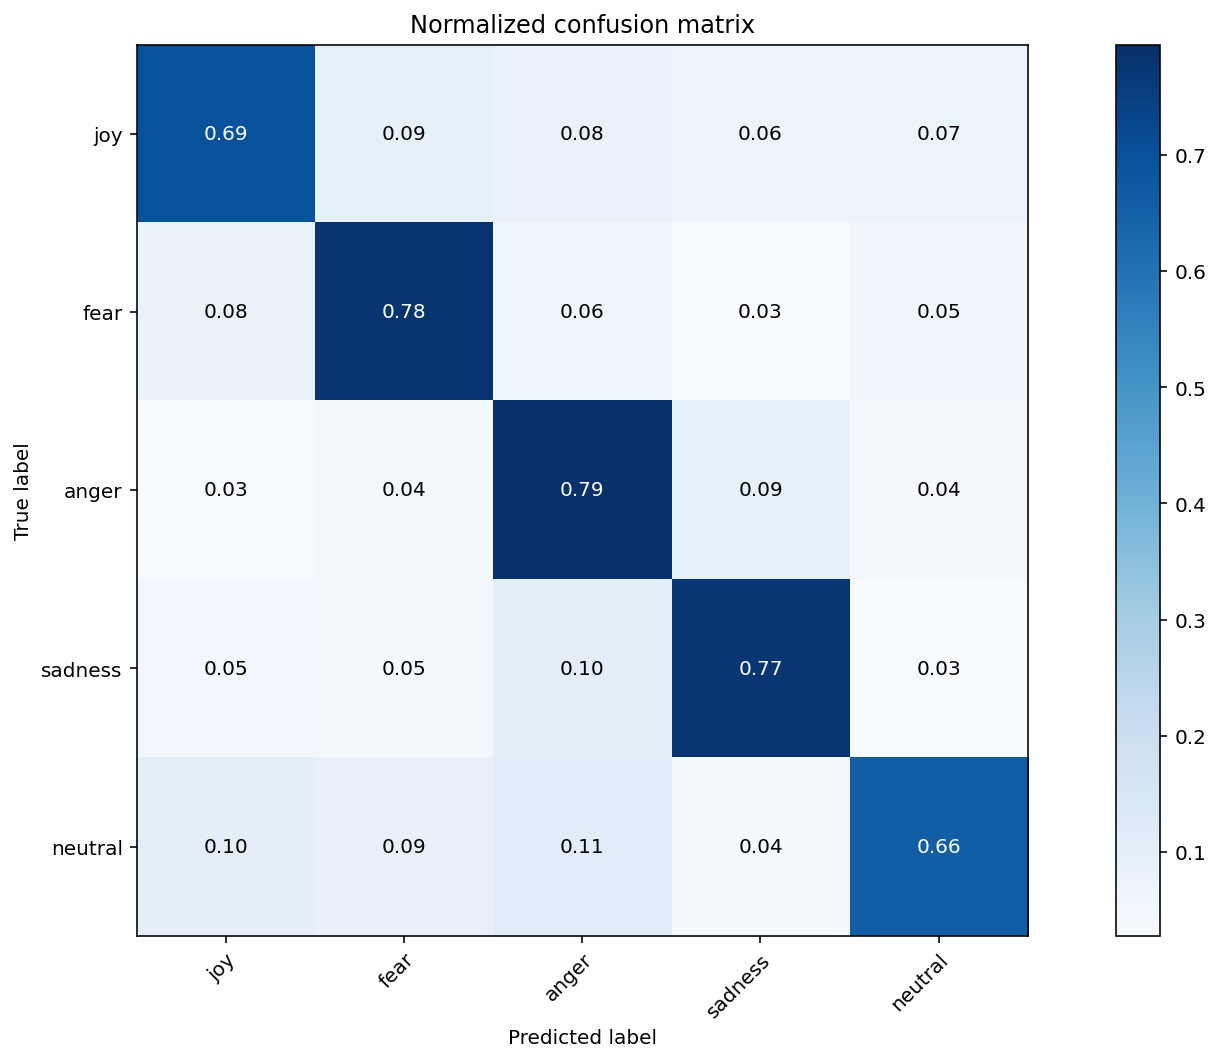

In [72]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Lets try other inputs:

In [75]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [96]:
import time

message = ['i have been really going through rough days']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['i have been really going through rough days']
predicted: neutral (0.38 seconds)


# Voice Prediction:

In [77]:
#installing all the packages required for speech input and recognition

!sudo apt-get install portaudio19-dev python-pyaudio
!sudo apt-get install python-gnuradio-audio-portaudio
!pip install PyAudio
!pip install SpeechRecognition
!pip install pyttsx3
!pip install wavio
!pip install pydub

Reading package lists... Done
Building dependency tree       
Reading state information... Done
portaudio19-dev is already the newest version (19.6.0-1).
python-pyaudio is already the newest version (0.2.11-1build2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package python-gnuradio-audio-portaudio


In [84]:
# all imports
import numpy as np
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from pydub import AudioSegment

# js script needed to record input from colab
RECORD = """
const sleep = time => new Promise(resolve => {
setTimeout(resolve, time)
}, )
const b2text = blob => new Promise(resolve => {
const reader = new FileReader()
reader.onloadend = e => resolve(e.srcElement.result)
reader.readAsDataURL(blob)
})
var espacio = document.querySelector("#output-area")
var record = time => new Promise(async resolve => {
stream = await navigator.mediaDevices.getUserMedia({ audio: true })
recorder = new MediaRecorder(stream)
chunks = []
recorder.ondataavailable = e => chunks.push(e.data)
recorder.start()
var numerillo = (time/1000)-1
for (var i = 0; i < numerillo; i++) {
espacio.appendChild(document.createTextNode(numerillo-i))
await sleep(1000)
espacio.removeChild(espacio.lastChild)
}
recorder.onstop = async ()=>{
blob = new Blob(chunks)
text = await b2text(blob)
resolve(text)
}
recorder.stop()
})
"""

#record function that will record the audio for a default of 5 secs
def record(sec=5):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb') as f:
    f.write(b)
  return 'audio.wav'  # or webm ?


#conversion of the .wav file into a readable format for speechrecognizer
EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [97]:
#recognition of speech using SpeeechRecognition Package
import speech_recognition as sr
import time

r = sr.Recognizer()
n=int(input("Enter the number of seconds:"))
print("Speak Anything :")
print("Time Remaining:")
wave=record(n)
converted_audio_file = convert_audio_for_model(wave)

# obtain audio from the microphone
r = sr.Recognizer()
with sr.AudioFile('/content/converted_audio_file.wav') as source:
    audio = r.record(source) #read the wave file from the source

# recognize speech using Google Speech Recognition
try:
    # for testing purposes, we're just using the default API key
    # to use another API key, use `r.recognize_google(audio, key="GOOGLE_SPEECH_RECOGNITION_API_KEY")`
    # instead of `r.recognize_google(audio)`
    text=r.recognize_google(audio)
    print("You said:  " + text)
except sr.UnknownValueError:
    print("AI could not understand audio")
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))


# Python code to convert string to list
# We need it as input into the lstm pipeline is done with list and the output from the StT is in String  
def Convert(string):
    li = list(string.split(" "))
    return li

#Message encoding
message = [' '.join(Convert(text))]

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Enter the number of seconds:10
Speak Anything :
Time Remaining:


<IPython.core.display.Javascript object>

You said:  I really don't like going to the doctor
predicted: fear (0.32 seconds)




---

# Audio Graphs for the voice

In [86]:
#Installing the dependencies
!pip install pysoundfile
!pip install bitstring
!sudo apt-get install -q -y timidity libsndfile1
!pip install pydub numba==0.48 librosa music21

Reading package lists...
Building dependency tree...
Reading state information...
timidity is already the newest version (2.13.2-41).
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [98]:
#Plotting the audio in notebook
import IPython
IPython.display.Audio('converted_audio_file.wav')


Sampling rate: 16000 samples/second
Signal size: 144000 samples
Signal duration: 9.000 seconds


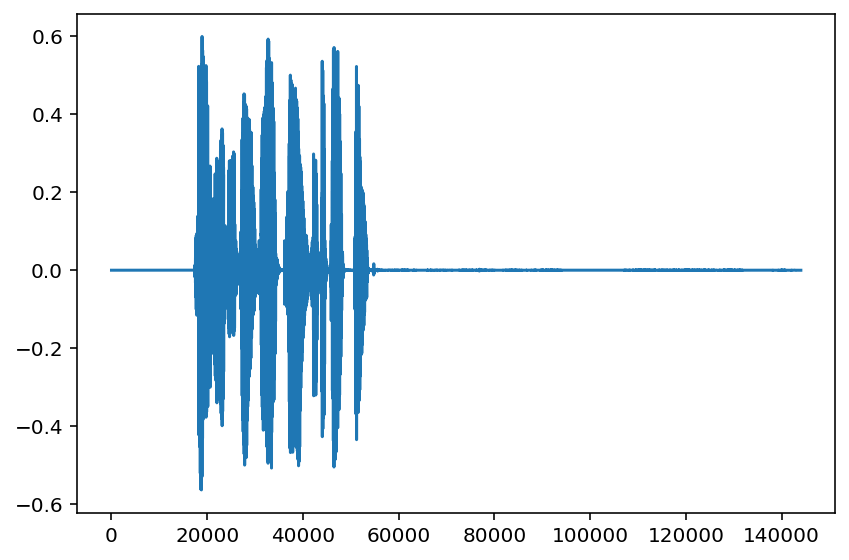

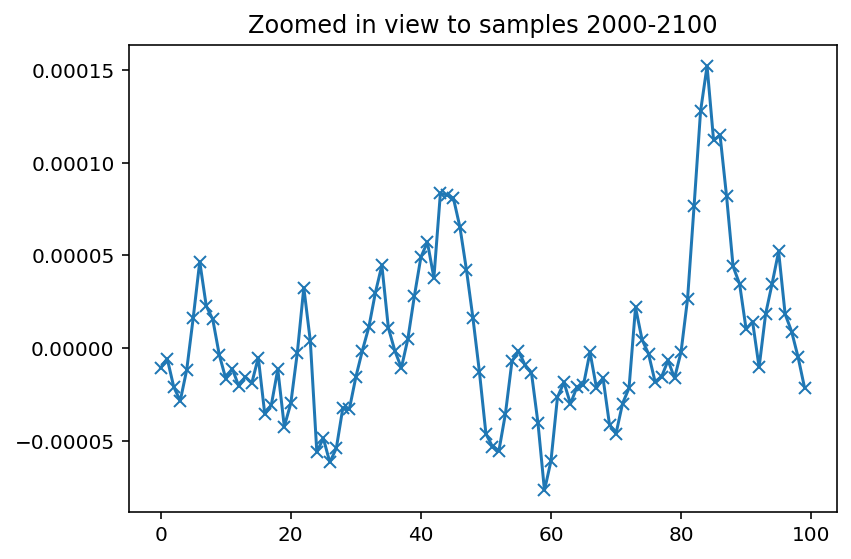

In [99]:
#plotting the audio signal

import soundfile
import matplotlib.pyplot as plt
audio_signal, sampling_rate = soundfile.read('converted_audio_file.wav')
print('Sampling rate: {} samples/second'.format(sampling_rate))
print('Signal size: {} samples'.format(audio_signal.shape[0]))
print('Signal duration: {:.3f} seconds'.format(audio_signal.shape[0] / sampling_rate))
plt.plot(audio_signal)
plt.tight_layout()
plt.figure()
plt.plot(audio_signal[2000:2100], marker='x')
plt.title('Zoomed in view to samples 2000-2100')
plt.tight_layout()

**Using short time fourier transform to obtain magnitude spectogram of speech**

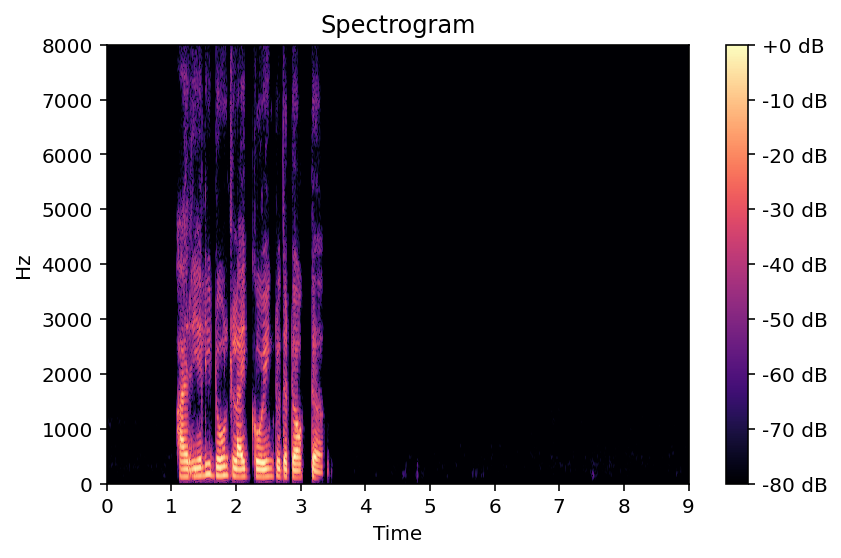

In [100]:
# Short time Fourier transform (STFT) splits signal into small frames ( 25 ms),
# so that consecutive frames are overlapping (below the overlap is  25−10=15 ms). 
# Then, Fourier transform is applied to all frames individually.
# Fourier transform gives complex valued outputs.
# In spectrogram representation of speech only the magnitudes of the complex values are used.
# Magnitudes can be obtained using NumPy's abs() function.

# We use Librosa's STFT implementation.


#importing the file
import numpy as np
import librosa
from librosa.display import specshow

window_length = int(0.025 * sampling_rate)
hop_length = int(0.01 * sampling_rate)

spectrogram = np.abs(librosa.stft(audio_signal, hop_length=hop_length, win_length=window_length))

# Plotting the spectrogram:
specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [90]:
# Printing the Numpy Array Obtained (2d Spectrogram)
print(spectrogram.shape)

(1025, 901)


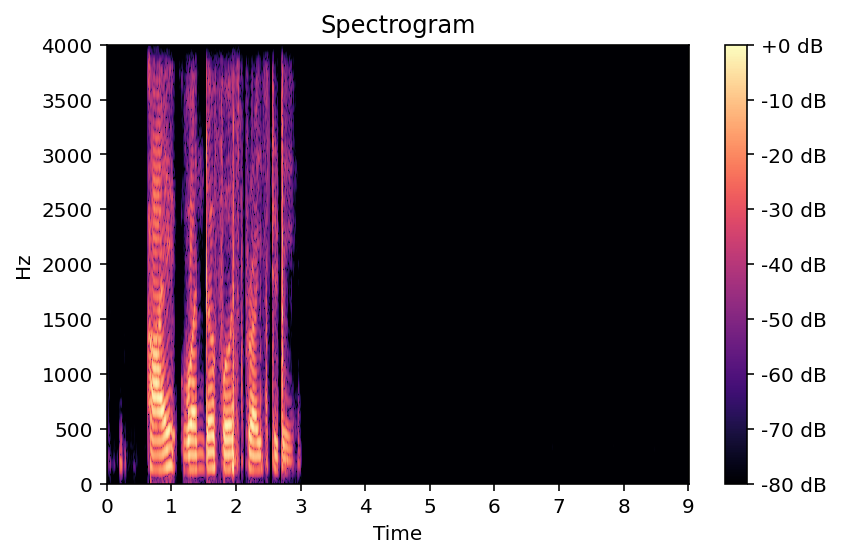

In [91]:
#Resampling the audio at 8 kHz.
audio_signal = librosa.resample(audio_signal, sampling_rate, 8000)
sampling_rate = 8000

window_length = int(0.025 * sampling_rate)
hop_length = int(0.01 * sampling_rate)

spectrogram = np.abs(librosa.stft(audio_signal, hop_length=hop_length, win_length=window_length))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()